In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file
from bokeh.models import Legend, HoverTool, ColumnDataSource

excel_file = 'EU_disasters.xlsx'

df = pd.read_excel(excel_file)

df.drop(columns=['Historic', 'Classification Key','External IDs', 'Event Name','OFDA/BHA Response','Appeal','Declaration',"AID Contribution ('000 US$)", 'Magnitude','Magnitude Scale', 'Latitude','Longitude','River Basin','Start Day','Total Deaths','No. Injured','No. Affected','No. Homeless','Total Affected',"Reconstruction Costs ('000 US$)", 
                 "Reconstruction Costs, Adjusted ('000 US$)","Insured Damage ('000 US$)", "Insured Damage, Adjusted ('000 US$)", "Total Damage ('000 US$)","Total Damage, Adjusted ('000 US$)",'CPI', "Admin Units","Entry Date", 'Last Update','Origin','Associated Types'], inplace=True)


df['Start Year'] = pd.to_datetime(df['Start Year'], format='%Y').dt.year


generic_colors = ['red', 'yellow', 'purple', 'blue', 'green', 'black', 'gray', 'pink', 'brown',
                  'skyblue', 'darkorange', 'lightseagreen', 'cyan', 'magenta', 'lime', 'gold',
                  'indigo', 'teal', 'salmon', 'peru', 'olive', 'orchid', 'steelblue','black']

disaster_colors = {
    "Flood": "blue",
    "Storm": "red",
    "Earthquake": "green",
    "Epidemic": "orange",
    "Glacial lake outburst flood": "purple",
    "Extreme temperature" :"magenta",
    "Mass movement (wet)":"lime",
    "Volcanic activity":"indigo",
    "Wildfire":"steelblue",
    "Drought":"peru",
    "Impact": "teal",
    "Infestation":"olive",
    "Mass movement (dry)":"magenta",
    

}


In [15]:
filter_natural = df[df['Disaster Group'] == 'Natural']

grouped_natural_disaster = filter_natural.groupby('Disaster Group')

#grouped_natural_disaster.head()

In [16]:
##### To print and see all the data when data is natural
natural_disaster_group = grouped_natural_disaster.get_group('Natural')
print(natural_disaster_group)

for group_name, group_data in grouped_natural_disaster:
    print("Group:", group_name)
    print(group_data)


             DisNo. Disaster Group Disaster Subgroup        Disaster Type  \
1     2000-0028-ROU        Natural    Meteorological                Storm   
2     2000-0029-BGR        Natural    Meteorological  Extreme temperature   
7     2000-0052-RUS        Natural        Biological             Epidemic   
9     2000-0072-BIH        Natural      Hydrological  Mass movement (wet)   
10    2000-0076-ISL        Natural       Geophysical           Earthquake   
...             ...            ...               ...                  ...   
1818  2024-0129-CHE        Natural    Meteorological                Storm   
1819  2024-0129-ESP        Natural    Meteorological                Storm   
1820  2024-0129-FRA        Natural    Meteorological                Storm   
1821  2024-0129-ITA        Natural    Meteorological                Storm   
1822  2024-0183-FRA        Natural      Hydrological                Flood   

           Disaster Subtype  ISO                 Country        Subregion  

# sum of all disaster each year

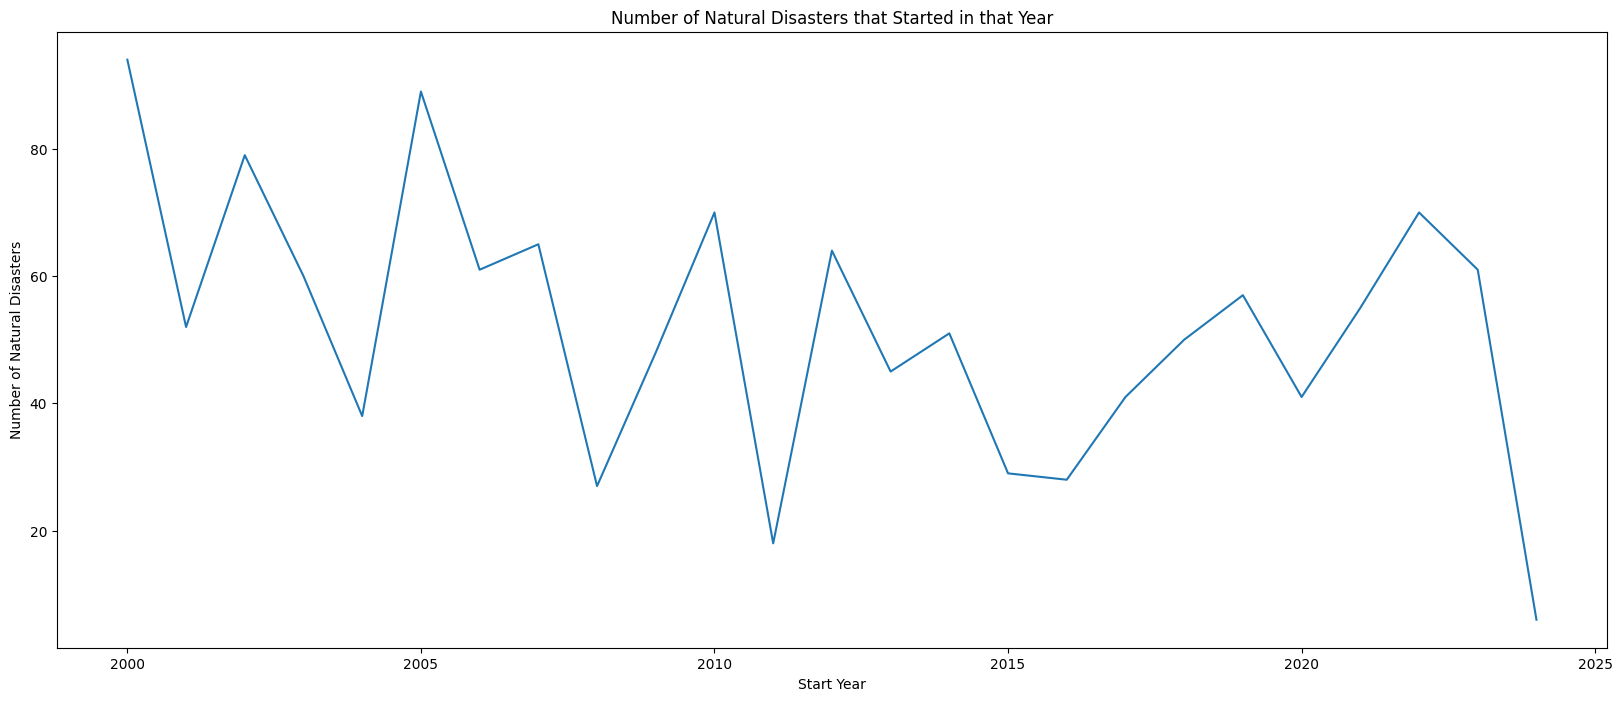

In [17]:
#### Plot for the sum of all disasters each year 
grouped_start_year = filter_natural.groupby('Start Year').size()

plt.figure(figsize=(20, 8))

plt.plot(grouped_start_year.index, grouped_start_year.values)

plt.xlabel('Start Year')
plt.ylabel('Number of Natural Disasters')
plt.title('Number of Natural Disasters that Started in that Year')

plt.savefig("natural_disasters_all_year_plot.png")

plt.show()


# disaster type in each year (individual plot)

In [23]:
##### Plot for each disaster type in each year (individual plot)
grouped_year = filter_natural.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
p = figure(x_range=grouped_year.index.astype(str).tolist(), height=500, width=1000, title="Number of Natural Disasters by Type and Year",
           toolbar_location=None, tools="")

disaster_types = grouped_year.columns.tolist()
bar_width = 1 / len(disaster_types)  
renderers = [] 

for i, disaster_type in enumerate(disaster_types):
    x_pos = [year + i * bar_width for year in range(len(grouped_year))]
    source = ColumnDataSource(data=dict(x=x_pos, top=grouped_year[disaster_type], name=[disaster_type] * len(x_pos), year=grouped_year.index.astype(str).tolist()))

    renderer = p.vbar(x='x', top='top', width=bar_width, color=disaster_colors[disaster_type], source=source)
    renderers.append(renderer)  
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Number of Disasters'
p.xaxis.major_label_orientation = np.pi / 4

hover = HoverTool(tooltips=[("Year", "@year"), ("Disaster Type", "@name"), ("Occurrence", "@top")], renderers=renderers)
p.add_tools(hover)

legend_items = [(disaster_type, [renderer]) for disaster_type, renderer in zip(disaster_types, renderers)]
legend = Legend(items=legend_items, location="top_right", click_policy='hide')
p.add_layout(legend, 'right')

output_file("extreme_weather_years.html")

show(p)


# Plot for sum disaster for each year

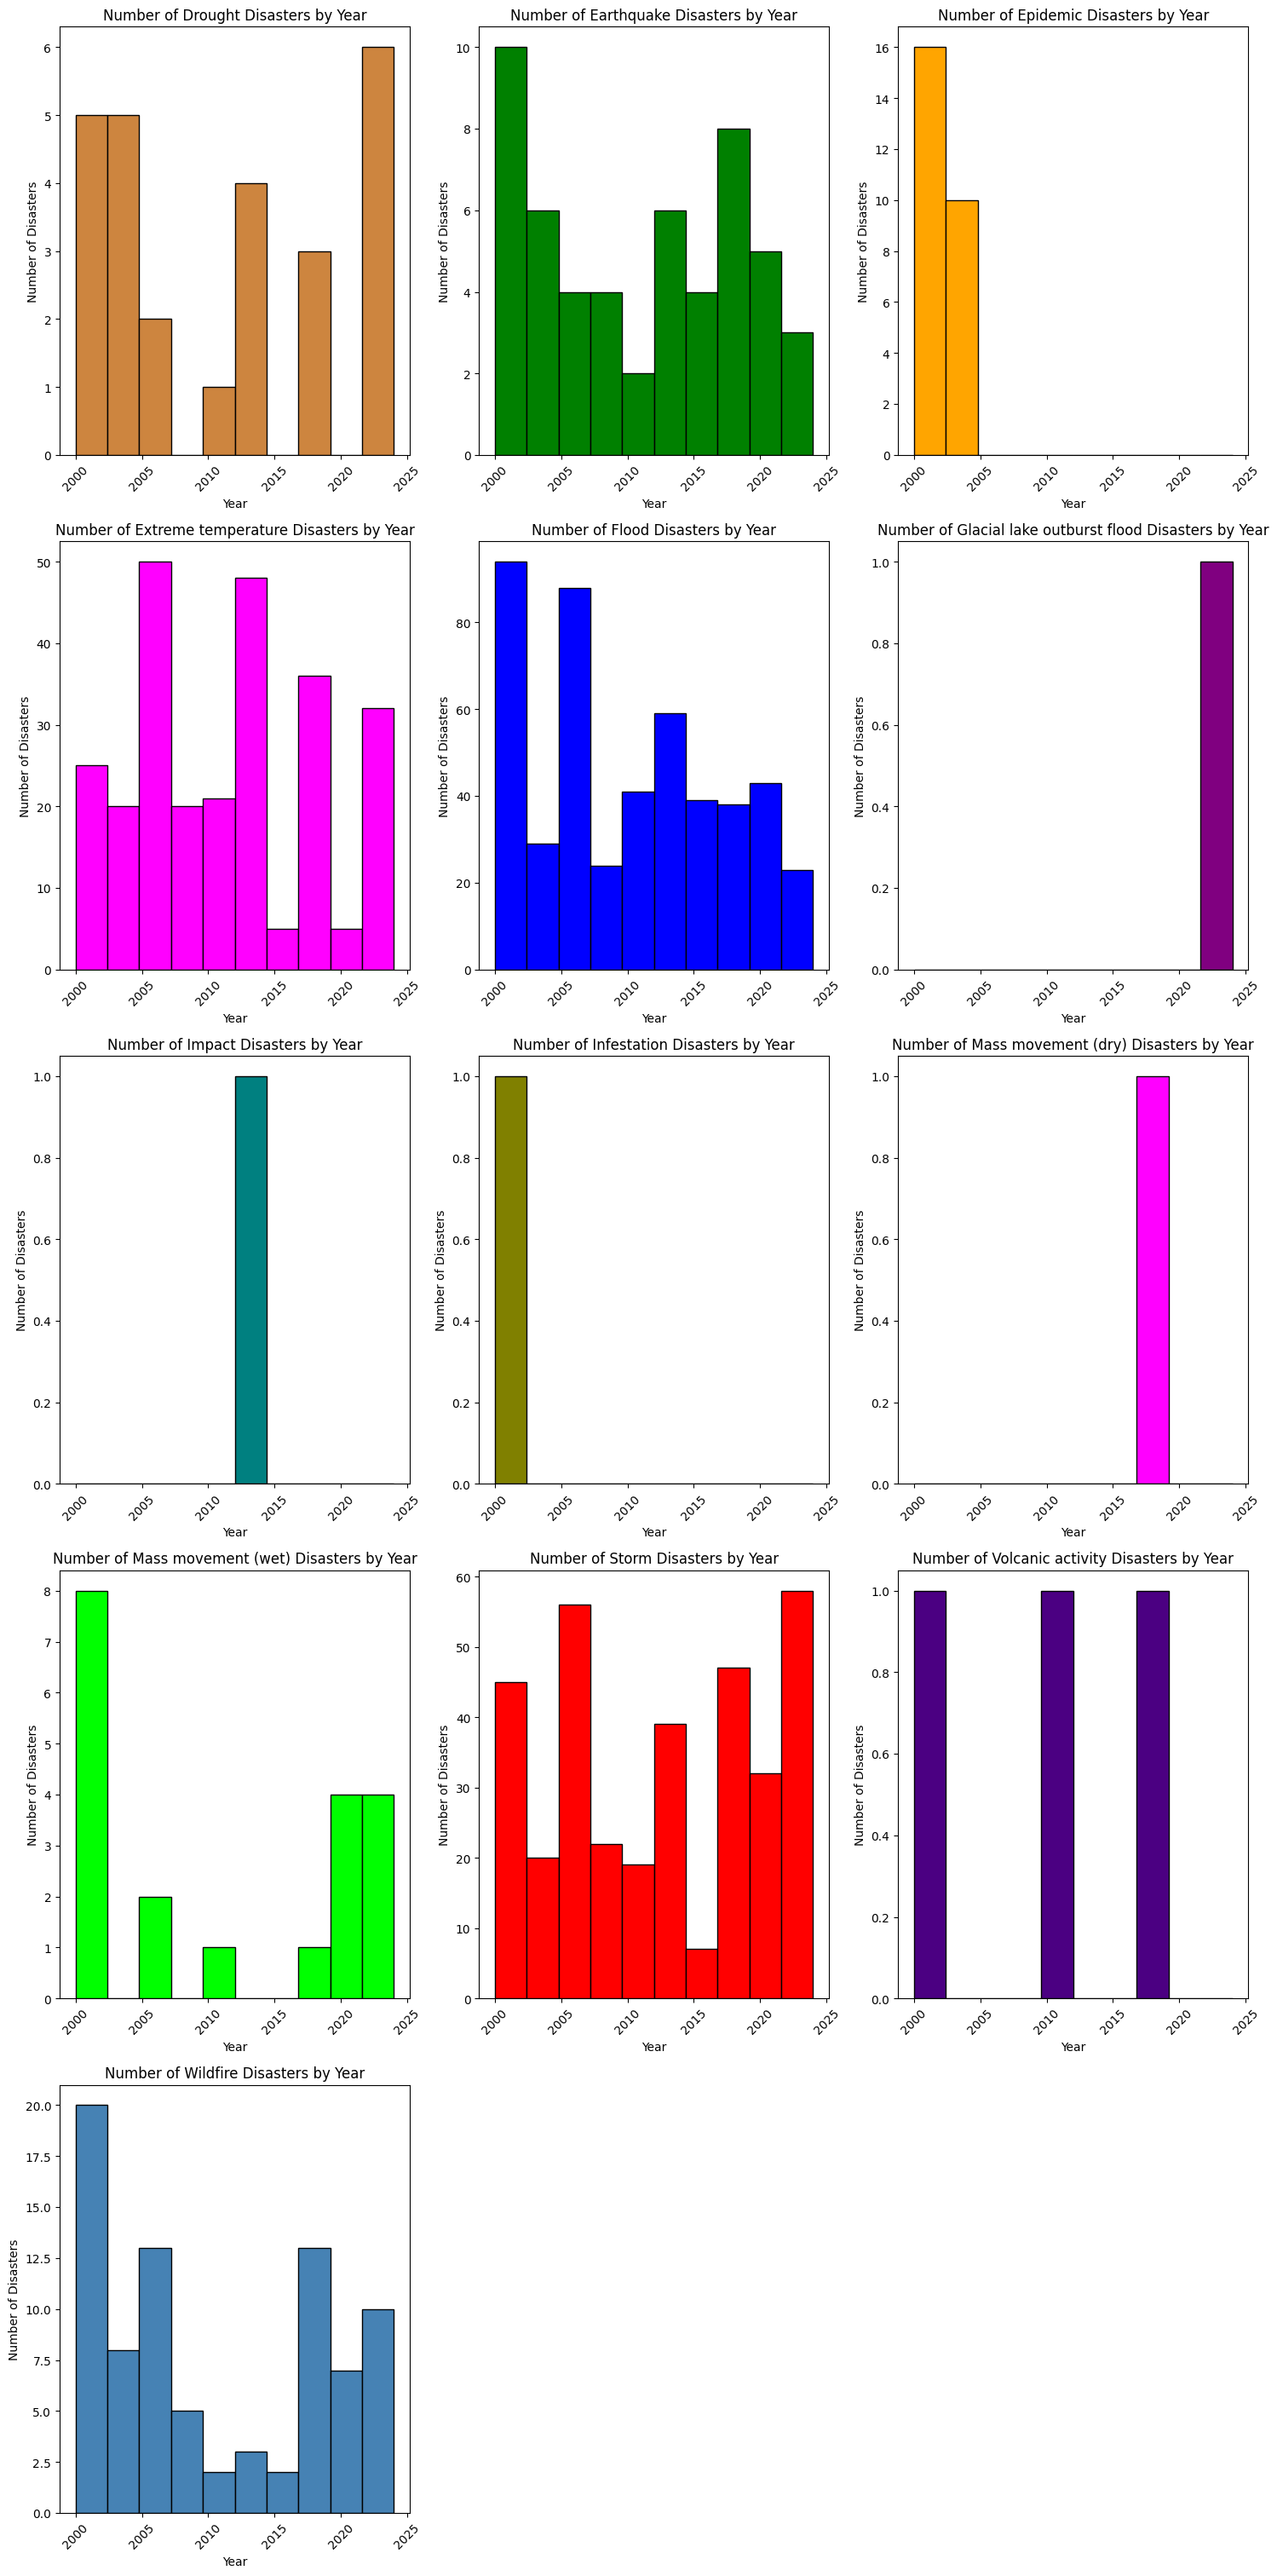

In [19]:
##### Plot for every year 

grouped = filter_natural.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)

num_disaster_types = len(grouped.columns)

plt.figure(figsize=(15, 6 * num_disaster_types))

for i, disaster_type in enumerate(grouped.columns):
    plt.subplot(num_disaster_types, 3, i + 1)
    plt.hist(grouped.index, weights=grouped[disaster_type], bins=10, color=disaster_colors[disaster_type], edgecolor='black')
    plt.xlabel('Year')
    plt.ylabel('Number of Disasters')
    plt.title(f'Number of {disaster_type} Disasters by Year')
    plt.xticks(rotation=45)
    #plt.grid(True)

plt.tight_layout()
plt.savefig("sum_of_all_disasters_each_plot.png")
plt.show()


# USE see if the same colors could be used for all plots, so they dont differ

In [22]:
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.models import Legend, HoverTool, ColumnDataSource
import numpy as np

grouped_country = filter_natural.groupby(['Country', 'Start Year', 'Disaster Type']).size().unstack(fill_value=0)

countries = grouped_country.index.get_level_values('Country').unique()

plots = []

num_countries = len(countries)
plots_per_row = 2
num_rows = (num_countries + plots_per_row - 1) // plots_per_row

disaster_names = []

for idx, country in enumerate(countries):
    country_data = grouped_country.loc[country]
    disaster_types = country_data.columns
    
    all_years = np.arange(country_data.index.min(), country_data.index.max() + 1)

    non_zero_disasters = [disaster_type for disaster_type in disaster_types if country_data[disaster_type].sum() > 0]

    p = figure(title=f'Number of Natural Disasters by Type and Year in {country}',
                x_axis_label='Year', y_axis_label='Number of Disasters',
                  x_range=(min(all_years)-1, max(all_years)+1), width = 475, height = 250)

    plotted_disaster_types = []

    for i, disaster_type in enumerate(non_zero_disasters):
        x = all_years
        y = country_data[disaster_type].reindex(all_years, fill_value=0)
        source = ColumnDataSource(data=dict(x=x, y=y, name=[disaster_type] * len(x)))
        bars = p.vbar(x='x', top='y', width=0.8, color=disaster_colors[disaster_type], alpha=0.5, source=source)
        plotted_disaster_types.append((disaster_type, [bars]))
        disaster_names.append(disaster_type)  

    p.xaxis.ticker = all_years
    p.xaxis.major_label_orientation = "vertical"
    p.yaxis.ticker = np.arange(0, 6, 1)
    legend = Legend(items=plotted_disaster_types, location="top_left", click_policy="hide")
    legend.spacing = 5
    legend.label_text_font_size = "6pt"
    p.add_layout(legend, 'right')

        #tooltips = [("Year", "@x"), ("Disaster Type", "@name"), ("Occurrences", "@y")]
    # hover = HoverTool(tooltips=tooltips, mode="vline")
    # p.add_tools(hover)

    plots.append(p)

grid = gridplot(plots, ncols=plots_per_row)

show(grid)

output_file("natural_disasters_each_country.html")

